In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda:0')

torch.manual_seed(121)

In [2]:
class PIRBN_1D(nn.Module):

    def __init__(self, centers, b_init=1.0, dtype=torch.float64):
        super().__init__()
        self.dtype = dtype

        self.register_buffer('centers', centers.to(dtype))
        self.N = centers.shape[0]

        self.b = nn.Parameter(b_init * torch.ones(1, self.N, dtype=dtype))  
        self.a = nn.Parameter(torch.randn(self.N, 1, dtype=dtype))          
        self.bias = nn.Parameter(torch.randn(1, dtype=dtype))               

    def forward(self, x):
        x_exp = x.unsqueeze(1)
        c_exp = self.centers.unsqueeze(0)

        dist_sq = torch.sum((x_exp - c_exp)**2, dim=2)
        rbf = torch.exp(-self.b**2 * dist_sq)
        u = torch.matmul(rbf, self.a) + self.bias
        return u

    def uxx(self, x):
        x = x.clone().detach().requires_grad_(True)
        u = self.forward(x)
        grad1 = torch.autograd.grad(
            u, x, grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        grad2 = torch.autograd.grad(
            grad1, x, grad_outputs=torch.ones_like(grad1),
            create_graph=True
        )[0]
        return u, grad1, grad2


In [3]:
e = torch.tensor(2**-4, dtype=torch.float64, device=device)  

def analytical(x):
    num = torch.exp(-x) - torch.exp(-x/e)
    den = torch.exp(torch.tensor(-1.0, dtype=torch.float64, device=device)) \
          - torch.exp(-1.0/e)
    return num / den


In [4]:
Nx = 64
xcenters = torch.linspace(-0.2, 1.2, Nx, dtype=torch.float64)
centers = torch.stack([xcenters, torch.zeros_like(xcenters)], dim=1).to(device)

Ncolloc = 1024
xcolloc = torch.rand(Ncolloc, 1, dtype=torch.float64).to(device)  

Nb = 128
xb0 = torch.zeros(Nb, 1, dtype=torch.float64).to(device) 
xb1 = torch.ones(Nb, 1, dtype=torch.float64).to(device)   

x_validate = torch.rand(1000, 1, dtype=torch.float64, device=device)


In [5]:
model = PIRBN_1D(centers, b_init=5.0, dtype=torch.float64).to(device)

print(f"PIRBN has {sum(p.numel() for p in model.parameters()):,} parameters")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


epochs = 10**5
print_interval = 10**4


PIRBN has 129 parameters


In [6]:
def loss_print(pde_loss, bc_loss, model, epoch):
    with torch.no_grad():
        u_pred_validate = model(x_validate)
        u_exact_validate = analytical(x_validate)
        l2_error = torch.sqrt(torch.mean((u_pred_validate - u_exact_validate)**2)) / \
                   torch.sqrt(torch.mean(u_exact_validate**2))

        print(f"\n Epoch {epoch:6d} | "
              f"PDE: {pde_loss.item():.2e} | BC: {bc_loss.item():.2e} | "
              f"L2_rel: {l2_error.item():.2e}")


def loss(model):

    u, ux, uxx = model.uxx(xcolloc)
    res = e * uxx + (1.0 + e) * ux + u
    pde_loss = torch.mean(res**2)


    u0, _, _ = model.uxx(xb0)
    u1, _, _ = model.uxx(xb1)

    bc1 = torch.mean((u0 - 0.0)**2)
    bc2 = torch.mean((u1 - 1.0)**2)
    bc_loss = bc1 + bc2

    total = pde_loss + bc_loss
    return total, pde_loss, bc_loss


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for epoch in tqdm(range(1, epochs + 1)):
    optimizer.zero_grad()
    total_loss, pde_loss, ic_loss = loss(model)

    total_loss.backward()
    optimizer.step()
    
    if epoch % print_interval == 0: 
         loss_print(pde_loss, ic_loss, model, epoch)

  0%|          | 0/100000 [00:00<?, ?it/s]/envs/common/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 10%|█         | 10010/100000 [02:08<18:20, 81.74it/s]


 Epoch  10000 | PDE: 7.13e-03 | BC: 4.46e-03 | L2_rel: 7.90e-02


 14%|█▍        | 14474/100000 [02:58<17:31, 81.31it/s] 


KeyboardInterrupt: 

Relative L2 error: 8.59e-01


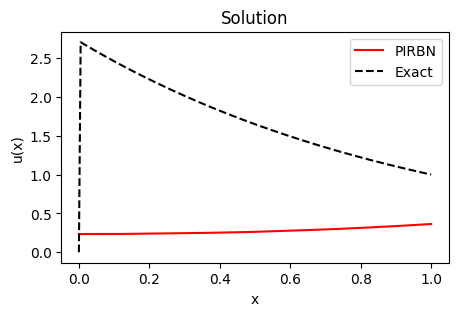

In [ ]:
N_eval = 200
x_eval = torch.linspace(0.0, 1.0, N_eval,
                        dtype=torch.float64, device=device).unsqueeze(1)

with torch.no_grad():
    u_pred_torch = model(x_eval)
    u_exact_torch = analytical(x_eval)

u_pred = u_pred_torch.cpu().numpy().ravel()
u_exact = u_exact_torch.cpu().numpy().ravel()
x_eval_np = x_eval.cpu().numpy().ravel()

l2_error = np.sqrt(np.mean((u_pred - u_exact)**2)) / np.sqrt(np.mean(u_exact**2))
print(f"Relative L2 error: {l2_error:.2e}")

plt.figure(figsize=(5, 3))
plt.plot(x_eval_np, u_pred, 'r-', label='PIRBN')
plt.plot(x_eval_np, u_exact, 'k--', label='Exact')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Solution')
plt.legend()
plt.show()
